In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
#from src.data import words_clusters

# DATA LOADING

In [2]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_movies = pd.read_csv(DATA + 'ratings_movies.csv', sep=',')
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

# DATA MERGING & CLEANING - Movies Dataset

In [3]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns
df_movies['missing_values'] = df_movies.isnull().sum(axis=1)

# for each title, find the row with the least missing values
df_movies = df_movies.loc[df_movies.groupby('title')['missing_values'].idxmin()]

# dropping 'missing_values' column
df_movies = df_movies.drop(columns=['missing_values'])

In [4]:
# doing the same duplicates cleaning as before for df_tmdb
df_tmdb['missing_values'] = df_tmdb.isnull().sum(axis=1)

# for each title, find the row with the least missing values
df_tmdb = df_tmdb.loc[df_tmdb.groupby('title')['missing_values'].idxmin()]

# dropping 'missing_values' column
df_tmdb = df_tmdb.drop(columns=['missing_values'])

In [5]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [6]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [7]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

In [8]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [9]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [10]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [11]:
# remove ' (yyyy)' from df_ratings_movies titles including any white spaces before parenthesis
df_ratings_movies['title'] = df_ratings_movies['title'].apply(cleaning.clean_titles)

`df_ratings_movies` might not be used

In [12]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

In [13]:
# retrieving mean ratings
mean_ratings = df_ratings_ratings.groupby(df_ratings_ratings["movieId"]).mean()
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 24056 unique movies in our movies dataset that have ratings given by the found dataset.


In [14]:
# binning ratings to match viewers regular rating style (.5 vote scale)
df_movies_tmdb_ratings['mean_rating_binned'] = df_movies_tmdb_ratings.mean_rating.mul(2).round().div(2)

In [15]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [16]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The mean number of genres of a given movie is:  5


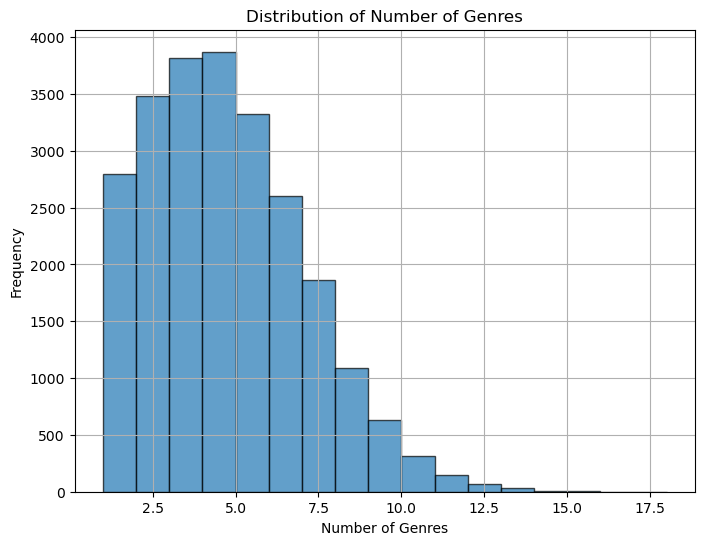

In [17]:
# getting the mean
print(f'The mean number of genres of a given movie is: ', math.ceil(df_movies_tmdb_ratings['genres'].apply(len).mean()))

# plotting the distribution
n_genres = df_movies_tmdb_ratings['genres'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_genres, bins=range(1, max(n_genres) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.grid(True)

In addition, when exploding only some relevant genre-wise movies copies will be kept. For example, if a movie has between genres 'Drama' and 'Acid western', with the first one being way more common than the second in the dataframe, only the movie copy with 'genre' == 'drama' is kept. This allows for a smaller influence of the explode operation on the overall statistics of the datframe, while maintaining a nice standard dataframe structure which is easy to handle genre-wise. 

In [18]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [19]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

Now that the genres column has been cleaned, a similar analysis needs to be performed for the 'spoken_languages' one and for 'countries'. Regarding the first one, since the TMDB dataset 'original_language' column has no missing values and has a standard format of one language per movie (e.g. en), this can be used without losing too much information or adding another heavy cleaning code. Considering the 'countries' column, one can follow a similar reasoning as before:

The mean number of countries of a given movie is:  2


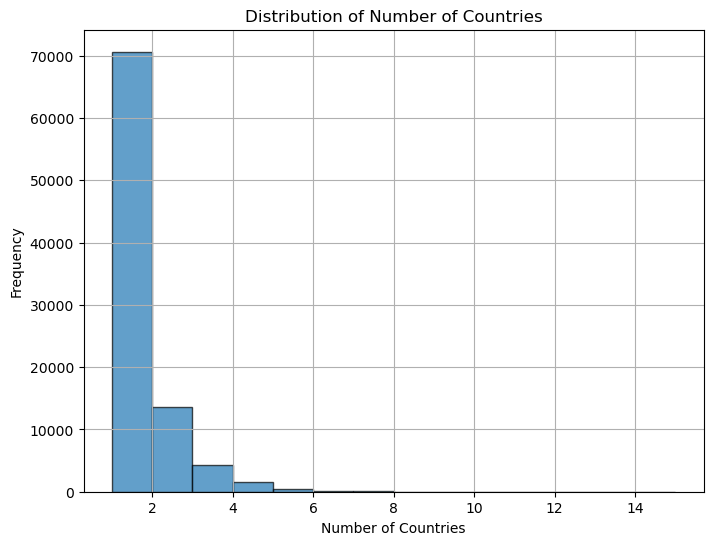

In [20]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

The distribution is heavily left-skewed. Therefore, exploding by countries will not alter the statistics of the dataframe in a too relevant way. Since the number of added entries through exploding is not too large and since one of the main interests of the team's datastory is the geographical analysis of movies, all countries will be kept (i.e. no relevant countries procedure will be applied, opposite to what has been done for genres). Note that, once again, depending on the interested analysis to be performed only one entry for a specific duplicated movie can be easily considered with the current dataframe structure.

In [21]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [22]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [24]:
unique_titles_now = len(df_movies_tmdb_ratings["title"].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 23229 unique movies in the standard movies dataset.
There were 75478 unique movies in the initial movies dataset.


# CLEANING - Characters Dataset

In [22]:
# clean characters 'release_date' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

As for now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize.